# SIMULATE THE SYSTEM

In [43]:
import simtk.openmm as mm       # Main OpenMM functionality
import simtk.openmm.app as app  # Application layer (handy interface)
import simtk.unit as unit       # Unit/quantity handling
import mdtraj
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

In [29]:
cwd = cwd = os.getcwd() 
solvent_solute_system = os.path.join(cwd, 'files/6a5j_protein/solv.pdb') 

molecule = app.PDBFile(solvent_solute_system)     # Load the solvated peptide

### (a) System object from topology of solvated peptide

In [30]:
forcefield = app.ForceField("amber14/protein.ff14SB.xml", "amber14/tip3p.xml")

system = forcefield.createSystem(
    molecule.topology,
    nonbondedMethod=app.PME,                 # Non-bonded interactions
    nonbondedCutoff=1 * unit.nanometer,      # Cut-off of non-bonded interactions 
    constraints=app.HBonds
    )

### (b) Simulation using Langevin integrator in timesteps of 2 fs at 300k

In [31]:
integrator = mm.LangevinIntegrator(300.*unit.kelvin, 1./unit.picosecond, 2.*unit.femtoseconds)

simulation = app.Simulation(
    molecule.topology,                      # Topology
    system,                                 # System
    integrator,                             # Integrator
    mm.Platform.getPlatformByName('CPU')    # Platform = 'CPU' or 'CUDA'
)

In [32]:
simulation.context.setPositions(molecule.positions)   # Add the current atomic positions of the solvated peptide 
                                                      # to the context of the simulation.

### (c) Energy minimization of the system

In [33]:
simulation.minimizeEnergy()

In [34]:
state = simulation.context.getState(getPositions=True)     # New co-ordinates
molecule.positions = state.getPositions()                 

In [35]:
minimized_system = os.path.join(cwd, 'files/6a5j_protein/min.pdb')

with open(minimized_system, "w") as file_:
    molecule.writeFile(
        molecule.topology, molecule.positions,
        file=file_
    )
    
# One can visualize this in VMD and see the difference between original and the minimised atoms

### (c) Equilibration of system in the NVT ensemble for 100 ps

In [36]:
molecule = app.PDBFile(minimized_system)
simulation.context.setPositions(molecule.positions)

In [37]:
run_length = 50000     # 50000 * 2 fs = 100 ps

equilibration_log = os.path.join(cwd, 'files/6a5j_protein/equilibration.log')

simulation.reporters.append(
    app.StateDataReporter(
        equilibration_log, 500, step=True,          # 500 = Write every 500th step
        potentialEnergy=True, totalEnergy=True,
        temperature=True, progress=True,
        remainingTime=True, speed=True,
        totalSteps=run_length,
        separator='\t')
    )

In [38]:
simulation.step(run_length)     # Run the simulation

In [39]:
save_state = os.path.join(cwd, 'files/6a5j_protein/eq.xml')
simulation.saveState(save_state)

In [40]:
pot_e = []
tot_e = []
temperature = []

with open(equilibration_log) as file_:
    for line in file_:
        if line.startswith("#"):
            continue
        pot_e_, tot_e_, temperature_ = line.split()[2:5]
        pot_e.append(float(pot_e_))
        tot_e.append(float(tot_e_))
        temperature.append(float(temperature_))

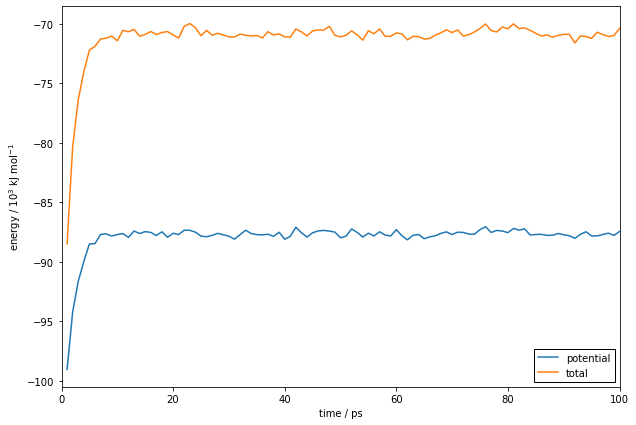

In [47]:
plt.rcParams["figure.figsize"] = (10,7)
t = range(1, 101)

fig, ax = plt.subplots()
ax.plot(t, [x / 1000 for x in pot_e], label="potential")
ax.plot(t, [x / 1000 for x in tot_e], label="total")

ax.set(**{
    "xlabel": "time / ps",
    "xlim": (0, 100),
    "ylabel": "energy / 10$^{3}$ kJ mol$^{-1}$"
    })

ax.legend(
    framealpha=1,
    edgecolor="k",
    fancybox=False
)

[Text(0, 0.5, 'temperature / K'), (0.0, 100.0), Text(0.5, 0, 'time / ps')]

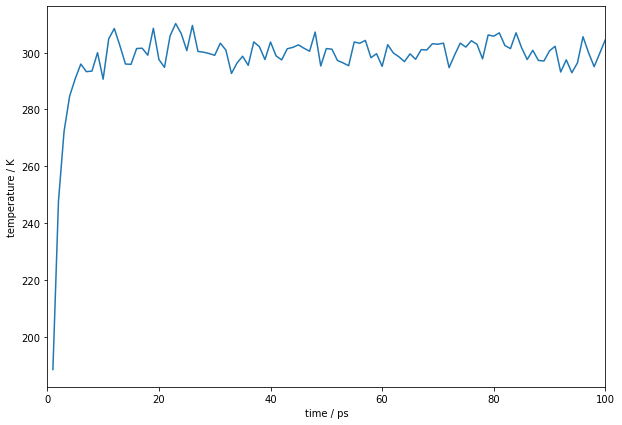

In [48]:
fig, ax = plt.subplots()
ax.plot(t, temperature)

ax.set(**{
    "xlabel": "time / ps",
    "xlim": (0, 100),
    "ylabel": "temperature / K"
    })

### (d) Production run (in CUDA)

In [ ]:
simulation.loadState(save_state)

simulation = os.path.join(cwd, 'files/6a5j_protein/simulation.log')

simulation.reporters = []          # Reset the simulation reporters

run_length = 375000000             # 375000000 * 2 fs = 750 ns
simulation.reporters.append(       
    app.StateDataReporter(         # State reporter that appends potential energy
        simulation, 5000, step=True,
        potentialEnergy=True,
        temperature=True, progress=True,
        remainingTime=True, speed=True,
        totalSteps=run_length,
        separator='\t')
    )

production_dcd = os.path.join(cwd, 'files/6a5j_protein/prod_run.dcd')

simulation.reporters.append(mdtraj.reporters.DCDReporter(
                    production_dcd, 5000,        # Structure reporter that appends positions
                    atomSubset=range(260))       # atomSubset = Save just the peptide atoms
                           )                     

In [ ]:
simulation.step(run_length)
# One can visualize the saved .dcd file in VMD and compare with th original